## SimCLR-V2 Training Framework

In [1]:
import timm
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.simclr_v2 import *

In [6]:
bs=128
resize, size = 160, 128

### 1. Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(resize, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, Resize(resize,method='squish')], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [5]:
list(L(timm.list_models()).filter(lambda o: "ssl" in o))

['ssl_resnet18',
 'ssl_resnet50',
 'ssl_resnext50_32x4d',
 'ssl_resnext101_32x4d',
 'ssl_resnext101_32x8d',
 'ssl_resnext101_32x16d']

In [11]:
arch_name = "ssl_resnext101_32x4d"

In [7]:
encoder = timm.create_model(arch_name, pretrained=False, num_classes=0)

In [8]:
dls = get_dls(resize, bs)
model = create_simclrv2_model(encoder=encoder, n_in=3, pretrained=False)
learn = Learner(dls, model, SimCLRv2Loss(temp=0.1), 
                cbs=[
                    SimCLRv2(resize, 
                             aug_func=get_batch_augs,
                             blur_s=(1,16)),
                    TerminateOnNaNCallback()])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> GaussBlur2D -- {'p': 0.3, 's': (1, 16), 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)} Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> GaussBlur2D -- {'p': 0.3, 's': (1, 16), 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


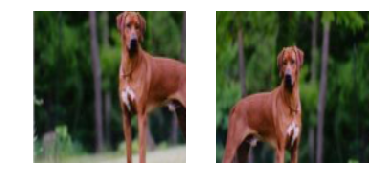

In [9]:
b = dls.one_batch()
learn._split(b)
learn.training = True
learn('before_batch')
learn.sim_cl_rv2.show_one()

In [10]:
learn.to_fp16();

In [11]:
lr=1e-3
epochs=100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,4.700577,4.748070,03:22
1,4.063446,4.451007,03:20
2,3.627293,3.764135,03:18
3,3.386178,3.429079,03:19
4,3.082767,3.201191,03:19
5,2.730067,3.022031,03:18
6,2.518048,2.887524,03:18
7,2.377192,2.186833,03:19
8,2.280228,2.464820,03:18
9,2.141824,2.427161,03:19


In [12]:
save_name = f'{arch_name}_simclrv2_iwang_sz{size}_epc100'

In [17]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

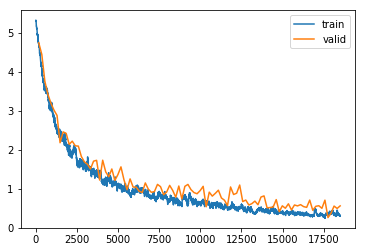

In [18]:
learn.recorder.plot_loss()

### [Optional] UMAP: Visualize Learned Representations

### 2. Fine-tuning

In [164]:
arch_name = "ssl_resnext101_32x4d"
save_name = f'{arch_name}_simclrv2_iwang_sz{size}_epc100'

In [165]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [166]:
dls = get_dls(size,bs=128)

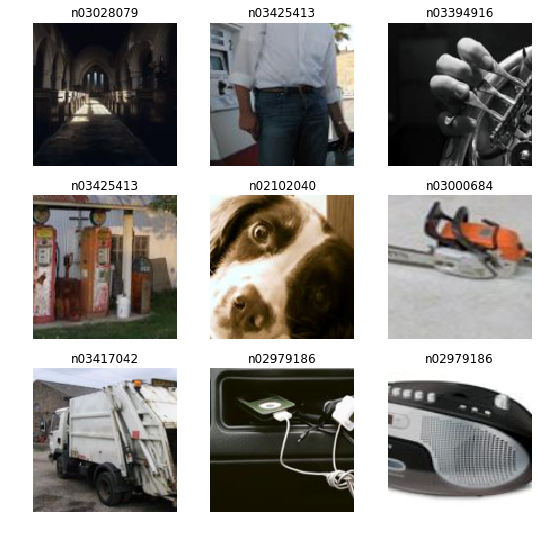

In [167]:
dls.show_batch()

In [168]:
pretrained_encoder = torch.load(f'./models/{save_name}_encoder.pth')
encoder = timm.create_model(arch_name, pretrained=False, num_classes=0)
encoder.load_state_dict(pretrained_encoder);

In [169]:
classification_head = create_head(2048, first_bn=True, n_out=dls.c, concat_pool=False)
classification_head = nn.Sequential(*classification_head[2:])
model = nn.Sequential(encoder, classification_head)

In [170]:
learn = Learner(dls, model, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy],
                loss_func=LabelSmoothingCrossEntropy())

In [171]:
learn.to_fp16();

In [172]:
epochs = 5
lr=1e-2
learn.unfreeze()
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.409425,2.407268,0.310766,0.762026,00:41
1,1.277395,2.209711,0.387121,0.817002,00:42
2,1.223080,2.270389,0.378468,0.791550,00:42
3,1.171160,2.158844,0.416900,0.814457,00:42
4,1.099511,2.005631,0.452532,0.857470,00:42


#### 2.1. Generate Pseudolabels for Full Data

In [173]:
def get_all_files(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source)
    return files

In [174]:
all_files = get_all_files(size,bs)

In [175]:
all_files

(#26348) [Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_2289.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/ILSVRC2012_val_00037999.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_4119.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_6689.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_4839.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_11499.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_989.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_3139.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_3849.JPEG'),Path('/root/.fastai/data/imagewang-160/train/n02096294/n02096294_3059.JPEG')...]

In [176]:
sup_and_unsup_dl = learn.dls.test_dl(all_files)

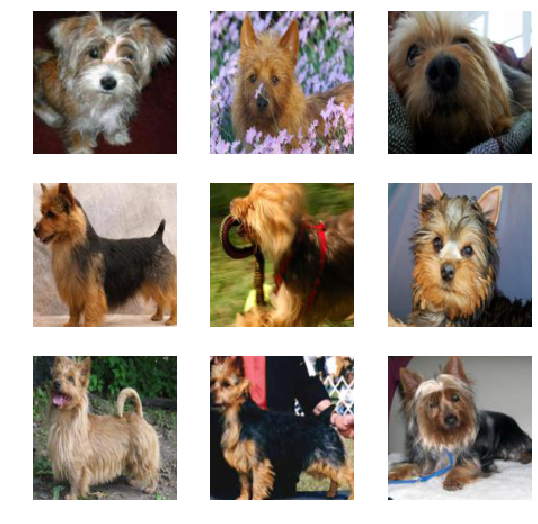

In [177]:
sup_and_unsup_dl.show_batch()

In [178]:
preds, _ = learn.get_preds(dl=sup_and_unsup_dl)

In [179]:
preds.argmax(1)[:20]

tensor([ 1,  6,  1,  6,  6,  6,  6,  6,  6,  6,  6,  9,  6,  6,  8,  6,  6,  6,
         8, 13])

In [180]:
Counter((all_files).map(lambda o: o.parent.parent.name))

Counter({'train': 14669, 'val': 3929, 'imagewang-160': 7750})

In [181]:
path2pseudolabel = dict(zip(all_files, preds))

In [182]:
len(path2pseudolabel)

26348

### 3. Knowledge-distillation

We will be training with probability predictions from the previous model as our labels during knowledge distillation. This will require minor changes in target format, loss function and metric function.

For unsupervised data we will use probability predictions as our target and for supervised data with actual ground truth we will use as weighted average of the actual label and probability predictions as following:

`unsupervised_label = probas`

`supervised_label = ohe_ground_truth*(1-smoothing) + probas*smoothing`


In [183]:
path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
source = untar_data(path)
files = get_image_files(source)
splits = GrandparentSplitter(valid_name='val')(files)

In [184]:
path2label = dict(zip(files, files.map(lambda o: o.parent.name)))

In [185]:
label_counts = Counter(path2label.values()); label_counts

Counter({'n02096294': 554,
         'n02093754': 547,
         'n02105641': 548,
         'n02089973': 299,
         'n03425413': 1350,
         'n01440764': 1350,
         'n03028079': 1350,
         'n02087394': 527,
         'n02111889': 567,
         'n03417042': 1350,
         'n03445777': 1350,
         'n02099601': 528,
         'n02088364': 559,
         'n03888257': 1350,
         'n02086240': 551,
         'n03394916': 1350,
         'n03000684': 1244,
         'n02979186': 1350,
         'n02115641': 524,
         'n02102040': 1350,
         'unsup': 7750})

In [186]:
label2id = {l:i for i,l in enumerate(set(label_counts.keys()).difference({"unsup"}))}

In [187]:
label2id

{'n03394916': 0,
 'n02088364': 1,
 'n03425413': 2,
 'n02086240': 3,
 'n02102040': 4,
 'n02089973': 5,
 'n02979186': 6,
 'n02096294': 7,
 'n03417042': 8,
 'n02115641': 9,
 'n02093754': 10,
 'n01440764': 11,
 'n02105641': 12,
 'n02087394': 13,
 'n03445777': 14,
 'n02111889': 15,
 'n03888257': 16,
 'n03028079': 17,
 'n03000684': 18,
 'n02099601': 19}

In [190]:
class PsuedoBlendLabel(DisplayedTransform):
    def __init__(self, path2label, path2pseudolabel, label2id, pseudo_conf=0, pseudo_smoothing=0.1, num_classes=20):
        store_attr()
        
    def encodes(self,o):
        label = path2label[o]
        pseudo_label = tensor(self.path2pseudolabel[o])
        if label == 'unsup':
            res = pseudo_label
            label_id = -1
        else:
            label_id = label2id[label]
            ohe_label = F.one_hot(tensor(label_id), self.num_classes).float()
            if pseudo_label.max().item() < self.pseudo_conf: 
                res = ohe_label
            else:                                                
                res = (1-self.pseudo_smoothing)*ohe_label + self.pseudo_smoothing*pseudo_label
        return res, label_id
    
    def show(self, **kwargs): 
        show_title(self.item(), **kwargs)

From SimCLRV2 paper: `"While we focus on distillation using only
unlabeled examples in this work, when the number of labeled examples is significant, one can also
combine the distillation loss with ground-truth labeled examples using a weighted combination"`

In [191]:
class CrossEntropyLossOneHot(Module):
    def __init__(self, sup_wgt=None):
        store_attr()

    def forward(self,preds,targs):
        ohe_labels, label_ids = targs
        if self.sup_wgt is None:
            return torch.mean(torch.sum(-ohe_labels * F.log_softmax(preds, -1)))
    
def ohe_accuracy(preds,targs): 
    ohe_labels,label_ids = targs
    return accuracy(preds, label_ids)

In [192]:
item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
tfms = [[PILImage.create, ToTensor, *item_aug], 
        [PsuedoBlendLabel(path2label, path2pseudolabel, label2id, pseudo_conf=0, pseudo_smoothing=0.1)]]

In [193]:
dsets = Datasets(files, tfms=tfms, splits=splits)

In [194]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [203]:
pretrained_encoder = torch.load(f'./models/{save_name}_encoder.pth')
encoder = timm.create_model(arch_name, pretrained=False, num_classes=0)
encoder.load_state_dict(pretrained_encoder);

In [205]:
classification_head = create_head(2048, first_bn=True, n_out=20, concat_pool=False)
classification_head = nn.Sequential(*classification_head[2:])
model = nn.Sequential(encoder, classification_head)

In [208]:
learn = Learner(dls, model, opt_func=opt_func,
                metrics=[ohe_accuracy],
                loss_func=CrossEntropyLossOneHot())

In [209]:
epochs = 5
lr=1e-2
learn.unfreeze()
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,ohe_accuracy,time
0,200.480118,315.091248,0.300585,00:36
1,153.954498,302.722565,0.330618,00:36
2,136.657593,281.905365,0.392466,00:36
3,130.671432,276.022430,0.396030,00:36
4,119.518730,264.381287,0.440825,00:37
